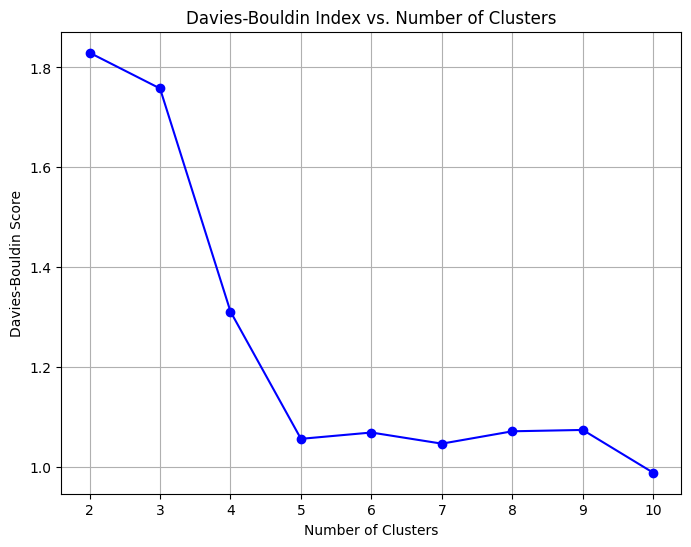

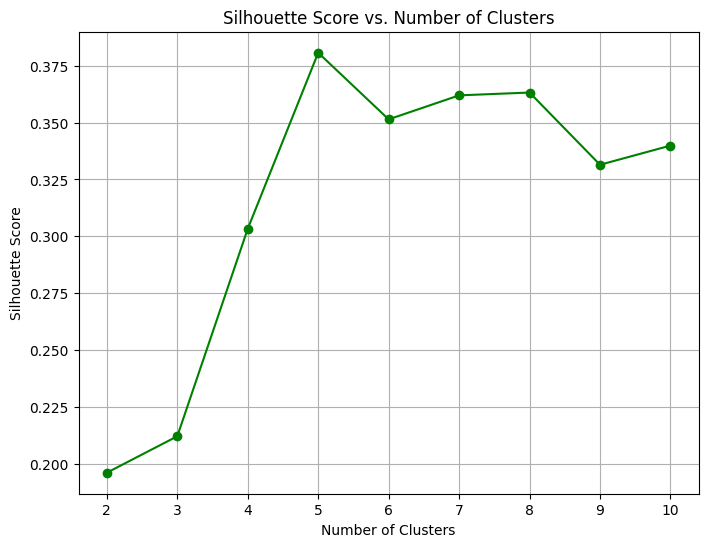

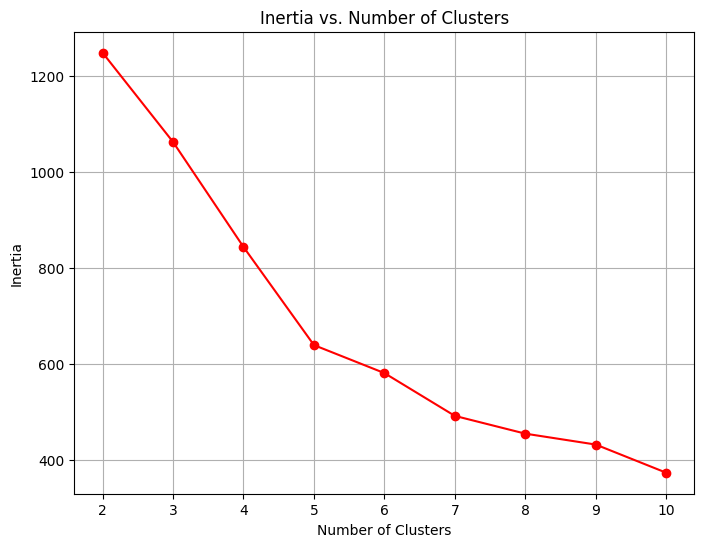

Davies-Bouldin Index: 1.3108541849674382
Silhouette Score: 0.3033150849478901


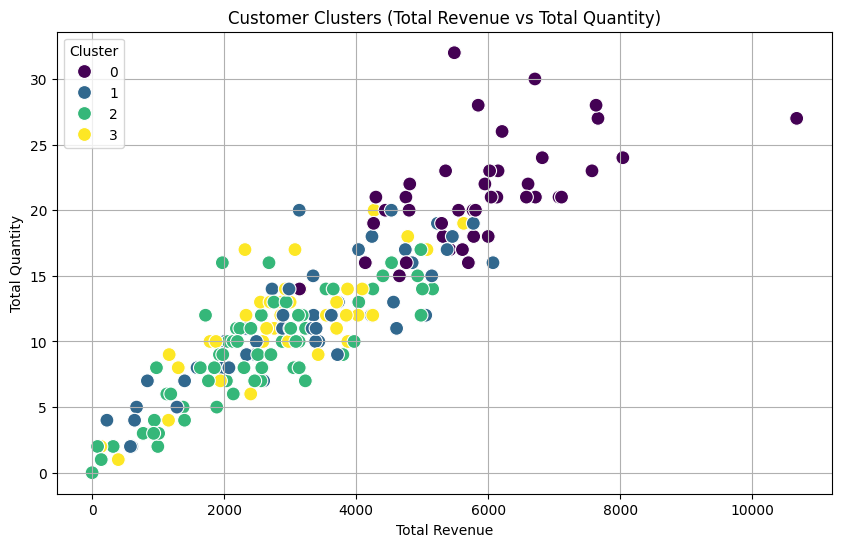

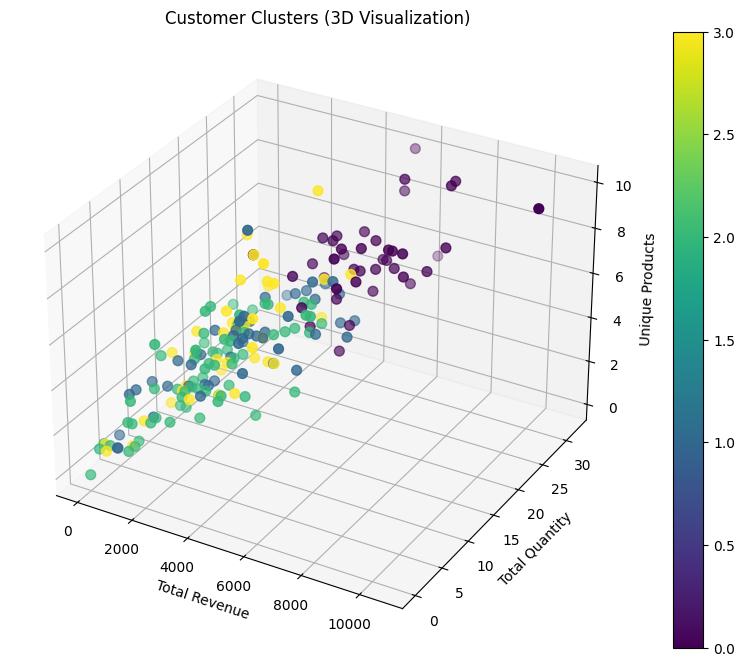

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load datasets
customers_url = "https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
transactions_url = "https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"

customers = pd.read_csv(customers_url)
transactions = pd.read_csv(transactions_url)

# 1. Merge and Preprocess Data
# Aggregate transaction data to create features
transaction_features = transactions.groupby("CustomerID").agg({
    "Quantity": "sum",
    "TotalValue": "sum",
    "ProductID": "nunique"
}).rename(columns={"Quantity": "TotalQuantity", "TotalValue": "TotalRevenue", "ProductID": "UniqueProducts"})

# Process customer data
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['AccountAge'] = (datetime.now() - customers['SignupDate']).dt.days

# Merge customer data with transaction features
customer_data = customers.merge(transaction_features, on="CustomerID", how="left").fillna(0)

# One-hot encode the 'Region' column
region_encoded = pd.get_dummies(customer_data['Region'], prefix='Region')
customer_data = pd.concat([customer_data, region_encoded], axis=1)

# Drop unnecessary columns
customer_data = customer_data.drop(columns=['CustomerName', 'SignupDate', 'Region'])

# 2. Select Features for Clustering
features = customer_data[['AccountAge', 'TotalQuantity', 'TotalRevenue', 'UniqueProducts'] + list(region_encoded.columns)]

# 3. Normalize Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 4. Determine Optimal Number of Clusters
db_scores = []
inertia_values = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)
    db_scores.append(davies_bouldin_score(features_scaled, clusters))
    silhouette_scores.append(silhouette_score(features_scaled, clusters))
    inertia_values.append(kmeans.inertia_)

# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), db_scores, marker='o', linestyle='-', label='Davies-Bouldin Score', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.grid()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', label='Silhouette Score', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid()
plt.show()

# Plot Inertia (Elbow Method)
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia_values, marker='o', linestyle='-', label='Inertia', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.grid()
plt.show()

# 5. Final Clustering
optimal_clusters = 4  # Replace with the optimal value found above
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans_final.fit_predict(features_scaled)

# 6. Evaluate Clustering
db_index = davies_bouldin_score(features_scaled, customer_data['Cluster'])
silhouette_avg = silhouette_score(features_scaled, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# 7. Save Clustering Results
customer_data.to_csv(r"C:\Users\YourName\Downloads\Customer_Clusters.csv", index=False)

# 8. Visualize Clusters (2D Visualization)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_data["TotalRevenue"],
    y=customer_data["TotalQuantity"],
    hue=customer_data["Cluster"],
    palette="viridis",
    s=100
)
plt.title("Customer Clusters (Total Revenue vs Total Quantity)")
plt.xlabel("Total Revenue")
plt.ylabel("Total Quantity")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# 3D Visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    customer_data["TotalRevenue"],
    customer_data["TotalQuantity"],
    customer_data["UniqueProducts"],
    c=customer_data["Cluster"],
    cmap='viridis',
    s=50
)
ax.set_title("Customer Clusters (3D Visualization)")
ax.set_xlabel("Total Revenue")
ax.set_ylabel("Total Quantity")
ax.set_zlabel("Unique Products")
plt.colorbar(sc)
plt.show()
